In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import cwt, ricker
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier
import os

In [2]:
data = pd.read_csv("/Users/dgagne/data/cabauw_derived_data_20190712.csv")
flux_data = pd.read_csv("/Users/dgagne/data/caubauw_csv/all_flux_data.20010101-20180201.csv")

In [46]:
data["log friction velocity_surface_m s-1"] = np.log10(data["friction velocity_surface_m s-1"])

In [3]:
data["s_flux_grad"] = data["sensible heat flux_surface_W m-2"] * data["potential temperature skin change_10 m_K m-1"]
data["l_flux_grad"] = (data["latent heat flux_surface_W m-2"] * data["mixing ratio skin change_10 m_g kg-1 m-1"] >= 0) 
data["flux_grad"] = (data["s_flux_grad"] >= 0) #&  (data["l_flux_grad"] > 0)

(array([0.1168965 , 0.12441853, 0.10069072, 0.11602522, 0.09456273,
        0.11637373, 0.0919489 , 0.09247166, 0.11971363, 0.16870851,
        0.28281692, 0.32269242, 0.33332201, 0.23239895, 0.16998638,
        0.15668487, 0.13914313, 0.15247369, 0.13574515, 0.11602522]),
 array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
        4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604,
        6.28318531]),
 <a list of 1 Patch objects>)

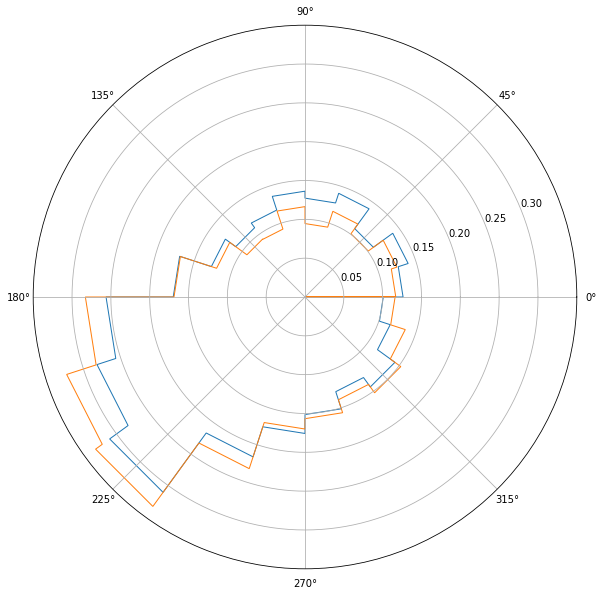

In [13]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

plt.hist(data.loc[data["flux_grad"]==1, "wind direction_10 m_degrees"] * np.pi / 180, bins=20, density=True, histtype="step")
plt.hist(data.loc[data["flux_grad"]==0, "wind direction_10 m_degrees"] * np.pi / 180, bins=20, density=True, histtype="step")

(array([24817., 27446., 21397., 27593., 25018., 26779., 23135., 21676.,
        24916., 33348., 50347., 55344., 61102., 42538., 34535., 29751.,
        25190., 28126., 22673., 19812.]),
 array([  0.,  18.,  36.,  54.,  72.,  90., 108., 126., 144., 162., 180.,
        198., 216., 234., 252., 270., 288., 306., 324., 342., 360.]),
 <a list of 20 Patch objects>)

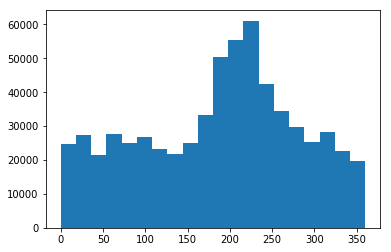

In [10]:
plt.hist(data.loc[data["flux_grad"]==1, "wind direction_10 m_degrees"], bins=20)

In [84]:
print(np.count_nonzero(data["s_flux_grad"] > 0))
print(np.count_nonzero(data["l_flux_grad"] > 0))
print(np.count_nonzero(data["flux_grad"]))

625542
541863
457330


2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:00
2005-02-01 00:00:00
2005-03-01 00:00:00
2005-04-01 00:00:00
2005-05-01 00:00:00
2005-06-01 00:00:00
2005-07-01 00:00:00
2005-08-01 00:00:00
2005-09-01 00:00:00
2005-10-01 00:00:00
2005-11-01 00:00:00
2005-12-01 00:00:00
2006-01-01 00:00:00
2006-02-01 00:00:00
2006-03-01 00:00:00
2006-04-01 00:00:00
2006-05-01 00:00:00
2006-06-01 00:00:00
2006-07-01 00:00:00
2006-08-01 00:00:00
2006-09-01 00:00:00
2006-10-01 00:00:00
2006-11-01 00:00:00
2006-12-01 00:00:00
2007-01-01 00:00:00
2007-02-01 00:00:00


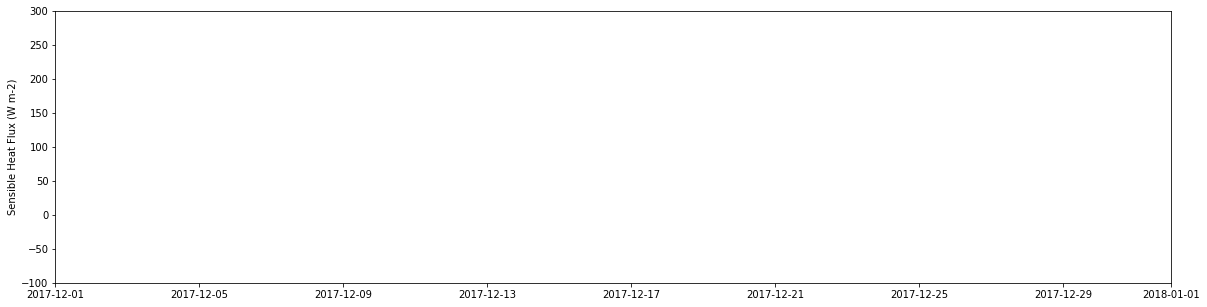

In [35]:
plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
         data.loc[data["flux_grad"], "sensible heat flux_surface_W m-2"], "b.")
plt.plot(pd.to_datetime(data.loc[~data["flux_grad"], "Time"]), 
         data.loc[~data["flux_grad"], "sensible heat flux_surface_W m-2"], "r.")
#plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
#         data.loc[data["flux_grad"], "latent heat flux_surface_W m-2"], ".")
plt.plot(pd.to_datetime(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.ylim(-100, 300)
plt.ylabel("Sensible Heat Flux (W m-2)")
dates = pd.date_range(start="2002-12-31", end="2017-12-31", freq="1M") + pd.Timedelta(days=1)
for d in range(len(dates[:-1])):
    print(dates[d])
    date_str = dates[d].strftime("%Y_%m")
    plt.xlim(dates[d], dates[d + 1])
    plt.savefig(f"sflux_times/sflux_{date_str}.png", dpi=150, bbox_inches="tight")


2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:00
2005-02-01 00:00:00
2005-03-01 00:00:00
2005-04-01 00:00:00
2005-05-01 00:00:00
2005-06-01 00:00:00
2005-07-01 00:00:00
2005-08-01 00:00:00
2005-09-01 00:00:00
2005-10-01 00:00:00
2005-11-01 00:00:00
2005-12-01 00:00:00
2006-01-01 00:00:00
2006-02-01 00:00:00
2006-03-01 00:00:00
2006-04-01 00:00:00
2006-05-01 00:00:00
2006-06-01 00:00:00
2006-07-01 00:00:00
2006-08-01 00:00:00
2006-09-01 00:00:00
2006-10-01 00:00:00
2006-11-01 00:00:00
2006-12-01 00:00:00
2007-01-01 00:00:00
2007-02-01 00:00:00


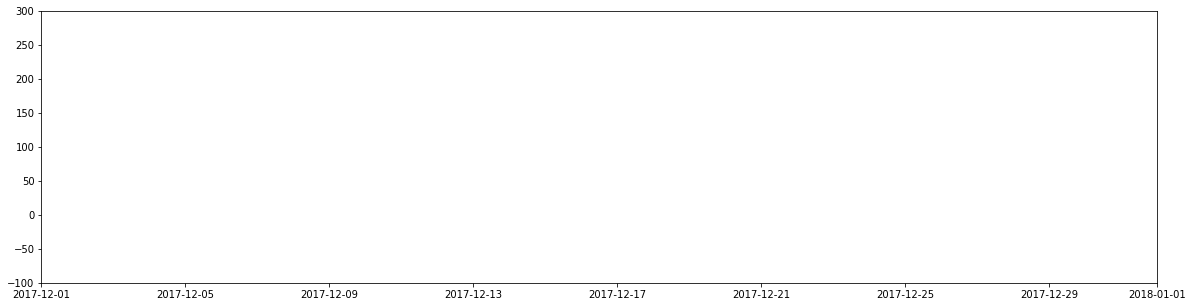

In [33]:
plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(data.loc[data["l_flux_grad"], "Time"]), 
         data.loc[data["l_flux_grad"], "latent heat flux_surface_W m-2"], "b.")
plt.plot(pd.to_datetime(data.loc[~data["l_flux_grad"], "Time"]), 
         data.loc[~data["l_flux_grad"], "latent heat flux_surface_W m-2"], "r.")
#plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
#         data.loc[data["flux_grad"], "latent heat flux_surface_W m-2"], ".")
plt.plot(pd.to_datetime(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.ylim(-100, 300)
dates = pd.date_range(start="2002-12-31", end="2017-12-31", freq="1M") + pd.Timedelta(days=1)
for d in range(len(dates[:-1])):
    print(dates[d])
    date_str = dates[d].strftime("%Y_%m")
    plt.xlim(dates[d], dates[d + 1])
    plt.savefig(f"lflux_times/lflux_{date_str}.png", dpi=150, bbox_inches="tight")


2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:00
2005-02-01 00:00:00
2005-03-01 00:00:00
2005-04-01 00:00:00
2005-05-01 00:00:00
2005-06-01 00:00:00
2005-07-01 00:00:00
2005-08-01 00:00:00
2005-09-01 00:00:00
2005-10-01 00:00:00
2005-11-01 00:00:00
2005-12-01 00:00:00
2006-01-01 00:00:00
2006-02-01 00:00:00
2006-03-01 00:00:00
2006-04-01 00:00:00
2006-05-01 00:00:00
2006-06-01 00:00:00
2006-07-01 00:00:00
2006-08-01 00:00:00
2006-09-01 00:00:00
2006-10-01 00:00:00
2006-11-01 00:00:00
2006-12-01 00:00:00
2007-01-01 00:00:00
2007-02-01 00:00:00


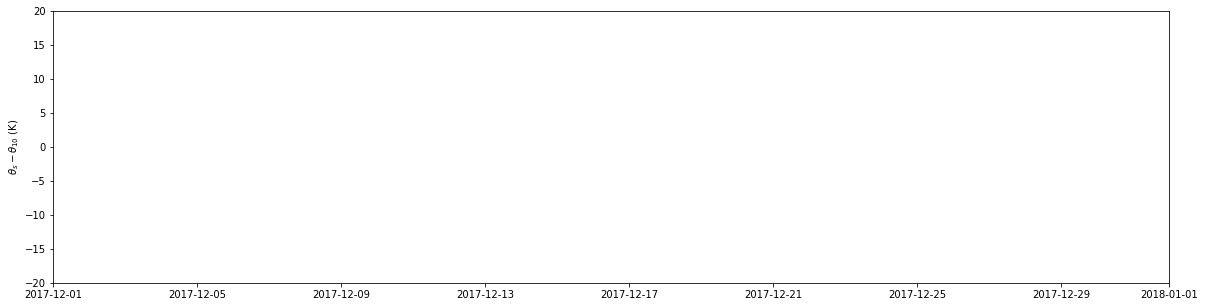

In [34]:
plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
         data.loc[data["flux_grad"], "potential temperature skin change_10 m_K m-1"] * 10, "b.")
plt.plot(pd.to_datetime(data.loc[~data["flux_grad"], "Time"]), 
         data.loc[~data["flux_grad"], "potential temperature skin change_10 m_K m-1"] * 10, "r.")
#plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
#         data.loc[data["flux_grad"], "latent heat flux_surface_W m-2"], ".")
plt.plot(pd.to_datetime(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.ylim(-20, 20)
plt.ylabel("$\\theta_{s}-\\theta_{10}$ (K)")
dates = pd.date_range(start="2002-12-31", end="2017-12-31", freq="1M") + pd.Timedelta(days=1)
for d in range(len(dates[:-1])):
    print(dates[d])
    date_str = dates[d].strftime("%Y_%m")
    plt.xlim(dates[d], dates[d + 1])
    plt.savefig(f"tdiff_times/tdiff_{date_str}.png", dpi=150, bbox_inches="tight")


2003-01-01 00:00:00
2003-02-01 00:00:00
2003-03-01 00:00:00
2003-04-01 00:00:00
2003-05-01 00:00:00
2003-06-01 00:00:00
2003-07-01 00:00:00
2003-08-01 00:00:00
2003-09-01 00:00:00
2003-10-01 00:00:00
2003-11-01 00:00:00
2003-12-01 00:00:00
2004-01-01 00:00:00
2004-02-01 00:00:00
2004-03-01 00:00:00
2004-04-01 00:00:00
2004-05-01 00:00:00
2004-06-01 00:00:00
2004-07-01 00:00:00
2004-08-01 00:00:00
2004-09-01 00:00:00
2004-10-01 00:00:00
2004-11-01 00:00:00
2004-12-01 00:00:00
2005-01-01 00:00:00
2005-02-01 00:00:00
2005-03-01 00:00:00
2005-04-01 00:00:00
2005-05-01 00:00:00
2005-06-01 00:00:00
2005-07-01 00:00:00
2005-08-01 00:00:00
2005-09-01 00:00:00
2005-10-01 00:00:00
2005-11-01 00:00:00
2005-12-01 00:00:00
2006-01-01 00:00:00
2006-02-01 00:00:00
2006-03-01 00:00:00
2006-04-01 00:00:00
2006-05-01 00:00:00
2006-06-01 00:00:00
2006-07-01 00:00:00
2006-08-01 00:00:00
2006-09-01 00:00:00
2006-10-01 00:00:00
2006-11-01 00:00:00
2006-12-01 00:00:00
2007-01-01 00:00:00
2007-02-01 00:00:00


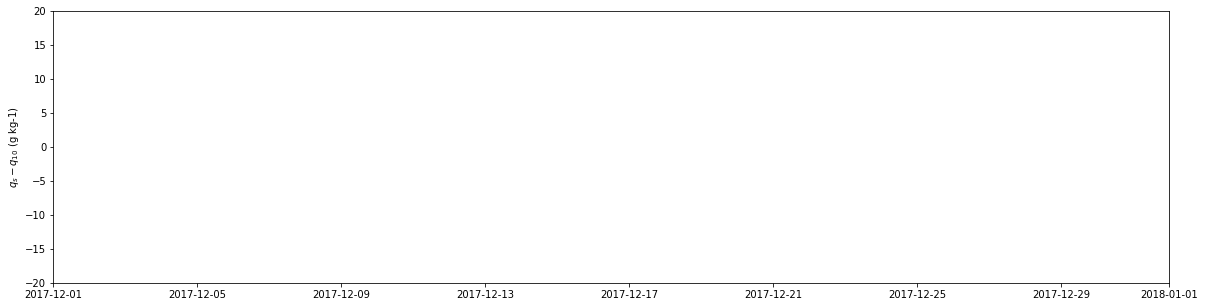

In [32]:
plt.figure(figsize=(20, 5))

plt.plot(pd.to_datetime(data.loc[data["l_flux_grad"], "Time"]), 
         data.loc[data["l_flux_grad"], "mixing ratio skin change_10 m_g kg-1 m-1"] * 10 , "b.")
plt.plot(pd.to_datetime(data.loc[~data["l_flux_grad"], "Time"]), 
         data.loc[~data["l_flux_grad"], "mixing ratio skin change_10 m_g kg-1 m-1"] * 10, "r.")
#plt.plot(pd.to_datetime(data.loc[data["flux_grad"], "Time"]), 
#         data.loc[data["flux_grad"], "latent heat flux_surface_W m-2"], ".")
plt.plot(pd.to_datetime(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.ylim(-20, 20)
plt.ylabel("$q_{s}-q_{10}$ (g kg-1)")
dates = pd.date_range(start="2002-12-31", end="2017-12-31", freq="1M") + pd.Timedelta(days=1)
for d in range(len(dates[:-1])):
    print(dates[d])
    date_str = dates[d].strftime("%Y_%m")
    plt.xlim(dates[d], dates[d + 1])
    plt.savefig(f"qdiff_times/qdiff_{date_str}.png", dpi=150, bbox_inches="tight")


In [ ]:
data["mi"]

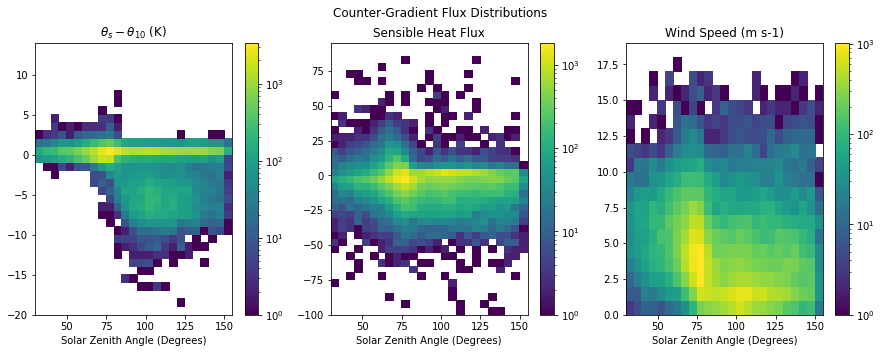

In [56]:
time = pd.DatetimeIndex(data["Time"])
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "potential temperature skin change_10 m_K m-1"] * 10, bins=(np.arange(30, 160, 5), np.arange(-20, 15)), cmin=1, 
               norm=LogNorm())
plt.title("$\\theta_{s}-\\theta_{10}$ (K)")
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.subplot(1,3,2)
_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "sensible heat flux_surface_W m-2"], bins=(np.arange(30, 160, 5), np.arange(-100, 100, 5)), cmin=1, 
               norm=LogNorm())
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.suptitle("Counter-Gradient Flux Distributions")
plt.title("Sensible Heat Flux")
plt.subplot(1,3,3)

_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "wind speed_10 m_m s-1"], bins=(np.arange(30, 160, 5), np.arange(0, 20, 1)), cmin=1, 
               norm=LogNorm())
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.title("Wind Speed (m s-1)")
plt.savefig("counter_grad_hist.png", dpi=200, bbox_inches="tight")

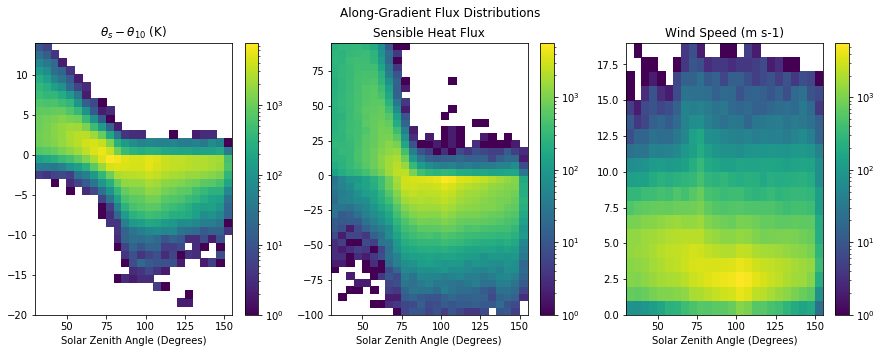

In [58]:
time = pd.DatetimeIndex(data["Time"])
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
_ = plt.hist2d(data.loc[data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[data["flux_grad"] & (time > "2010-01-01"), "potential temperature skin change_10 m_K m-1"] * 10, bins=(np.arange(30, 160, 5), np.arange(-20, 15)), cmin=1, 
               norm=LogNorm())
plt.title("$\\theta_{s}-\\theta_{10}$ (K)")
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.subplot(1,3,2)
_ = plt.hist2d(data.loc[data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[data["flux_grad"] & (time > "2010-01-01"), "sensible heat flux_surface_W m-2"], bins=(np.arange(30, 160, 5), np.arange(-100, 100, 5)), cmin=1, 
               norm=LogNorm())
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.suptitle("Along-Gradient Flux Distributions")
plt.title("Sensible Heat Flux")
plt.subplot(1,3,3)

_ = plt.hist2d(data.loc[data["flux_grad"] & (time > "2010-01-01"), "zenith_0 m_degrees"],
    data.loc[data["flux_grad"] & (time > "2010-01-01"), "wind speed_10 m_m s-1"], bins=(np.arange(30, 160, 5), np.arange(0, 20, 1)), cmin=1, 
               norm=LogNorm())
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.title("Wind Speed (m s-1)")
plt.savefig("along_grad_hist.png", dpi=200, bbox_inches="tight")

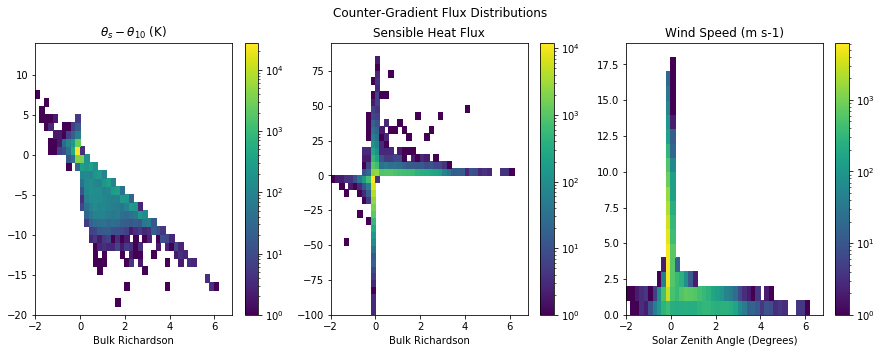

In [55]:
time = pd.DatetimeIndex(data["Time"])
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
x_axis = "bulk richardson_10 m_"
x_bins = np.arange(-2, 7, 0.2)
x_label = "Bulk Richardson"
_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"), x_axis],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "potential temperature skin change_10 m_K m-1"] * 10, 
               bins=(x_bins, np.arange(-20, 15)), cmin=1, 
               norm=LogNorm())
plt.title("$\\theta_{s}-\\theta_{10}$ (K)")
plt.xlabel(x_label)
plt.colorbar()
plt.subplot(1,3,2)
_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"), x_axis],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "sensible heat flux_surface_W m-2"], 
               bins=(x_bins, np.arange(-100, 100, 5)), cmin=1, 
               norm=LogNorm())
plt.xlabel(x_label)
plt.colorbar()
plt.suptitle("Counter-Gradient Flux Distributions")
plt.title("Sensible Heat Flux")
plt.subplot(1,3,3)

_ = plt.hist2d(data.loc[~data["flux_grad"] & (time > "2010-01-01"),x_axis],
    data.loc[~data["flux_grad"] & (time > "2010-01-01"), "wind speed_10 m_m s-1"], 
               bins=(x_bins, np.arange(0, 20, 1)), cmin=1, 
               norm=LogNorm())
plt.xlabel("Solar Zenith Angle (Degrees)")
plt.colorbar()
plt.title("Wind Speed (m s-1)")
plt.savefig("counter_grad_hist_br.png", dpi=200, bbox_inches="tight")

In [ ]:
data["bu"]

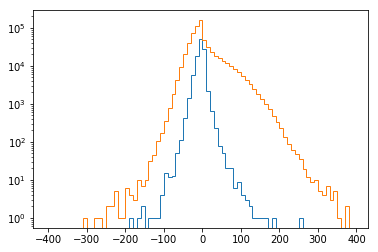

In [112]:
plt.hist(data.loc[~data["flux_grad"], "sensible heat flux_surface_W m-2"], bins=np.arange(-400, 400, 10), histtype="step")
plt.hist(data.loc[data["flux_grad"], "sensible heat flux_surface_W m-2"], bins=np.arange(-400, 400, 10), histtype="step")

plt.gca().set_yscale("log")

(array([ 24.,  16.,  14.,  11.,   7.,  11.,  10.,  11.,  10.,  14.,  15.,
         18.,  20.,  22.,  27.,  25.,  18.,  25.,  27.,  26.,  32.,  50.,
         57.,  50.,  62.,  56.,  59.,  74., 100.,  76., 103., 137., 123.,
        168., 157., 156., 168., 166., 157.,  90.,  64.,  52.,  31.,  23.,
         19.,  22.,  12.,  16.,  11.,  13.,  17.,  10.,  14.,  22.,  21.,
         20.,  21.,  22.,  19.,  13.,  19.,  21.,  19.,  20.,  31.,  16.,
         16.,  16.,  12.,  13.,  13.,  17.,  13.,  13.,  11.,   8.,  11.,
         12.,  14.,  12.,   5.,   4.,   6.,   9.,   7.,   6.,   5.,   9.,
         13.,   9.,   5.,  10.,   1.,   6.,   9.,   3.,  11.,   8.,  11.,
          5.]), array([ 28.54065222,  29.76779918,  30.99494614,  32.2220931 ,
         33.44924007,  34.67638703,  35.90353399,  37.13068095,
         38.35782791,  39.58497487,  40.81212184,  42.0392688 ,
         43.26641576,  44.49356272,  45.72070968,  46.94785664,
         48.17500361,  49.40215057,  50.62929753,  51.85644449,

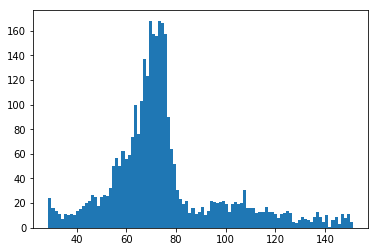

In [48]:
plt.hist(data.loc[(data["flux_grad"] < 0) & (data["sensible heat flux_surface_W m-2"] > 10), "zenith_0 m_degrees"], bins=100)

(array([ 19.,  26.,  32.,  28.,  31.,  56.,  46.,  42.,  42.,  54.,  46.,
         44.,  55.,  58.,  65.,  81.,  86.,  82.,  83.,  93.,  96., 117.,
        142., 142., 149., 158., 170., 190., 210., 278., 295., 314., 337.,
        370., 435., 517., 629., 671., 812., 687., 636., 623., 577., 525.,
        466., 459., 419., 403., 380., 353., 328., 342., 313., 324., 313.,
        312., 330., 355., 363., 356., 381., 467., 453., 391., 347., 304.,
        310., 304., 289., 283., 251., 245., 240., 265., 217., 235., 227.,
        263., 241., 210., 213., 228., 216., 205., 203., 186., 173., 188.,
        170., 195., 210., 182., 169., 194., 160., 158., 160., 161., 176.,
        186.]), array([ 28.54760734,  29.77681478,  31.00602223,  32.23522968,
         33.46443713,  34.69364457,  35.92285202,  37.15205947,
         38.38126691,  39.61047436,  40.83968181,  42.06888926,
         43.2980967 ,  44.52730415,  45.7565116 ,  46.98571905,
         48.21492649,  49.44413394,  50.67334139,  51.90254884,

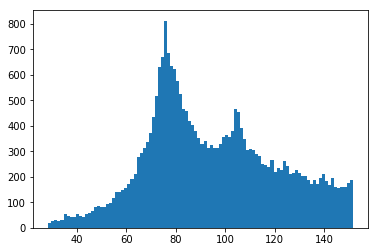

In [49]:
plt.hist(data.loc[(data["flux_grad"] < 0) & (data["sensible heat flux_surface_W m-2"] < -10), "zenith_0 m_degrees"], bins=100)

(array([  75.,   79.,   92.,   95.,   94.,  115.,  129.,  133.,  126.,
         148.,  150.,  160.,  174.,  190.,  195.,  247.,  235.,  241.,
         238.,  268.,  284.,  364.,  370.,  408.,  436.,  481.,  507.,
         583.,  672.,  749.,  830.,  963., 1050., 1217., 1366., 1499.,
        1706., 2043., 2426., 1954., 1767., 1647., 1434., 1290., 1156.,
        1110.,  952.,  961.,  920.,  865.,  897.,  878.,  887.,  924.,
         935.,  931., 1016., 1069., 1028., 1105., 1149., 1424., 1289.,
        1120., 1027.,  938.,  869.,  877.,  855.,  824.,  815.,  762.,
         793.,  783.,  713.,  640.,  660.,  691.,  665.,  671.,  598.,
         631.,  564.,  589.,  530.,  537.,  524.,  510.,  450.,  446.,
         469.,  407.,  393.,  386.,  361.,  352.,  355.,  345.,  385.,
         372.]), array([ 28.53433295,  29.76367314,  30.99301333,  32.22235352,
         33.45169371,  34.6810339 ,  35.9103741 ,  37.13971429,
         38.36905448,  39.59839467,  40.82773486,  42.05707505,
         43

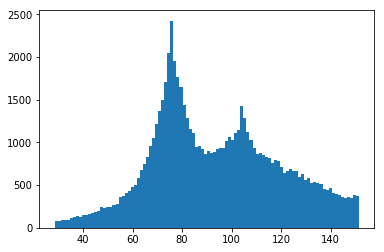

In [47]:
plt.hist(data.loc[data["flux_grad"] < -0.1, "zenith_0 m_degrees"], bins=100)

In [5]:
data["u diff_15 m_m s-1"] = data["u wind_20 m_m s-1"] - data["u wind_10 m_m s-1"]
data["v diff_15 m_m s-1"] = data["v wind_20 m_m s-1"] - data["v wind_10 m_m s-1"]
data["wind diff mag_15 m_m s-1"] = np.sqrt(data["u diff_15 m_m s-1"] ** 2 + data["v diff_15 m_m s-1"] ** 2)

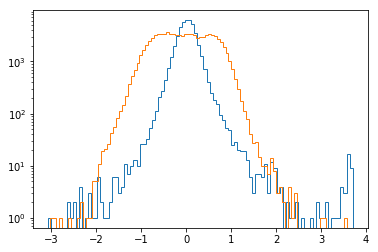

In [36]:
plt.hist(data.loc[ (data["bulk richardson_10 m_"] < -0.2),"v diff_15 m_m s-1"], bins=100, histtype="step")
plt.hist(data.loc[ (data["bulk richardson_10 m_"] > 0.2),"v diff_15 m_m s-1"], bins=100, histtype="step")

plt.gca().set_yscale("log")

(array([[       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 1.0000e+00, 1.0000e+00,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan, 1.0000e+00,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,

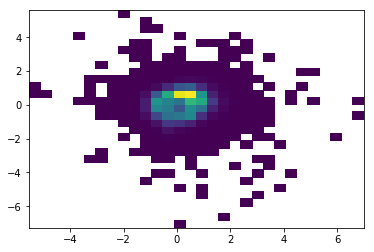

In [27]:
plt.hist2d(data.loc[(data["bulk richardson_10 m_"] > 0), "u diff_15 m_m s-1"], 
           data.loc[(data["bulk richardson_10 m_"] > 0), "v diff_15 m_m s-1"], bins=30, cmin=1)

(-100, 500)

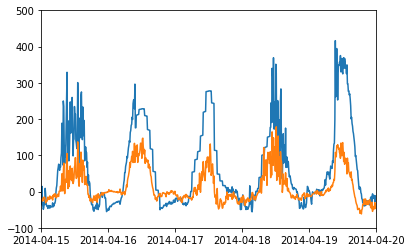

In [11]:
plt.plot(pd.to_datetime(flux_data["TimeStr"], format="%Y%m%d.%H:%M"), flux_data["LE"])
plt.plot(pd.to_datetime(flux_data["TimeStr"], format="%Y%m%d.%H:%M"), flux_data["H"])

plt.xlim("2014-04-15", "2014-04-20")
plt.ylim(-100, 500)

(735368.0, 735373.0)

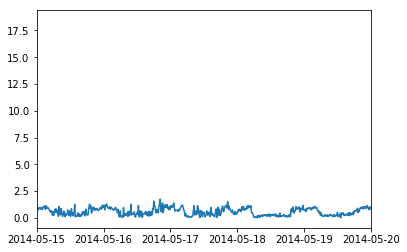

In [32]:
plt.plot(pd.to_datetime(data["Time"]), data["wind diff mag_15 m_m s-1"])

plt.xlim("2014-05-15", "2014-05-20")

(array([4.1294e+04, 5.4966e+04, 5.3664e+04, 3.4370e+04, 1.8175e+04,
        9.1680e+03, 5.5250e+03, 3.5720e+03, 2.3810e+03, 1.7030e+03,
        1.3490e+03, 1.0790e+03, 9.1800e+02, 7.8800e+02, 6.9900e+02,
        5.8500e+02, 5.7600e+02, 4.1900e+02, 4.5700e+02, 3.8800e+02,
        3.7600e+02, 3.0900e+02, 3.1500e+02, 2.9800e+02, 2.7200e+02,
        2.4800e+02, 2.2800e+02, 2.1200e+02, 2.3600e+02, 1.8500e+02,
        2.0000e+02, 1.7600e+02, 1.6000e+02, 1.6900e+02, 1.3500e+02,
        1.5500e+02, 1.2800e+02, 1.3600e+02, 1.2000e+02, 1.1700e+02,
        1.1100e+02, 1.0600e+02, 1.2200e+02, 9.0000e+01, 9.4000e+01,
        8.7000e+01, 7.8000e+01, 8.4000e+01, 7.9000e+01, 6.7000e+01,
        7.8000e+01, 7.4000e+01, 6.7000e+01, 5.9000e+01, 6.5000e+01,
        7.7000e+01, 5.0000e+01, 6.5000e+01, 4.4000e+01, 5.6000e+01,
        6.1000e+01, 4.5000e+01, 5.4000e+01, 4.8000e+01, 4.2000e+01,
        4.2000e+01, 4.0000e+01, 4.1000e+01, 4.9000e+01, 3.6000e+01,
        3.8000e+01, 5.0000e+01, 3.4000e+01, 3.00

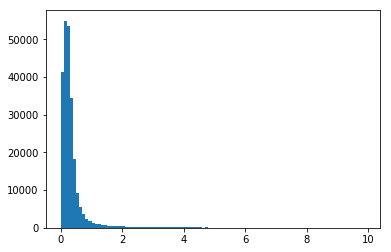

In [17]:
plt.hist((data["sensible heat flux_surface_W m-2"] / data["latent heat flux_surface_W m-2"]).loc[data["zenith_0 m_degrees"] < 90], 
         bins=np.arange(0, 10, 0.1))

(-100, 1000)

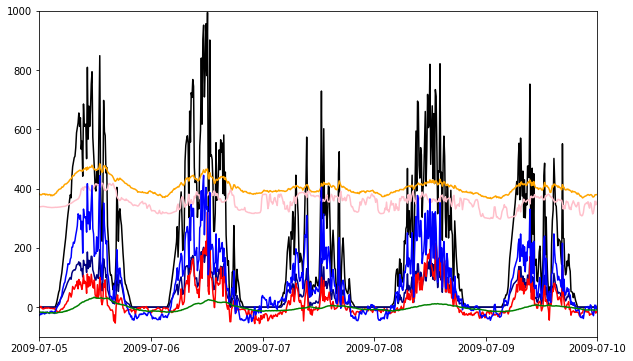

In [20]:
plt.figure(figsize=(10, 6))
time = pd.DatetimeIndex(data["Time"])
plt.plot(time, data["global horizontal irradiance_0 m_W m-2"], color="black")
plt.plot(time, data["upward shortwave irradiance_0 m_W m-2"], color="navy")
plt.plot(time, data["upward longwave irradiance_0 m_W m-2"], color="orange")
plt.plot(time, data["downward longwave irradiance_0 m_W m-2"], color="pink")
plt.plot(time, data["sensible heat flux_surface_W m-2"], color="red")
plt.plot(time, data["latent heat flux_surface_W m-2"], color="blue")
plt.plot(time, data["soil heat flux_surface_W m-2"], color="green")

plt.xlim("2009-07-05", "2009-07-10")
plt.ylim(-100, 1000)

In [26]:
r_net = data["global horizontal irradiance_0 m_W m-2"] - data["upward shortwave irradiance_0 m_W m-2"] \
    + data["downward longwave irradiance_0 m_W m-2"] - data["upward longwave irradiance_0 m_W m-2"]
r_turb_net = data["sensible heat flux_surface_W m-2"] + data["latent heat flux_surface_W m-2"] + data["soil heat flux_surface_W m-2"]

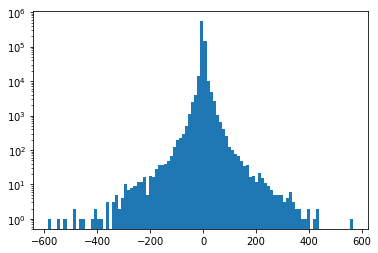

In [30]:
plt.hist(r_net - r_turb_net, bins=100)
plt.gca().set_yscale("log")

In [5]:
pt_diff = data["potential temperature_10 m_K"] - data["skin potential temperature_0 m_K"]
ch = np.maximum(data["friction velocity_surface_m s-1"], 0.1) * data["temperature scale_surface_K"] \
    / pt_diff

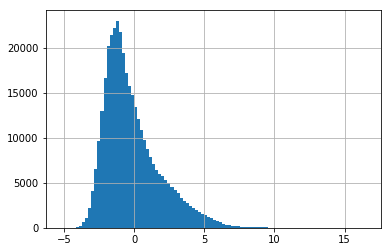

In [6]:
pt_diff[data["zenith_0 m_degrees"] > 90].hist(bins=100)

In [34]:
data["friction velocity_surface_m s-1"]

0         0.403107
1         0.382195
2         0.437964
3         0.411857
4         0.359413
5         0.476261
6         0.499015
7         0.361803
8         0.317639
9         0.442742
10        0.346854
11        0.451589
12        0.416376
13        0.440010
14        0.495700
15        0.403526
16        0.540988
17        0.288897
18        0.391937
19        0.365772
20        0.442186
21        0.393961
22        0.375645
23        0.270749
24        0.456950
25        0.351322
26        0.298885
27        0.330263
28        0.261607
29        0.357519
            ...   
735114    0.264607
735115    0.269582
735116    0.292988
735117    0.305824
735118    0.290976
735119    0.275573
735120    0.316758
735121    0.268469
735122    0.276904
735123    0.303364
735124    0.290508
735125    0.286527
735126    0.273965
735127    0.254209
735128    0.188108
735129    0.201811
735130    0.253536
735131    0.263617
735132    0.264809
735133    0.302010
735134    0.281667
735135    0.

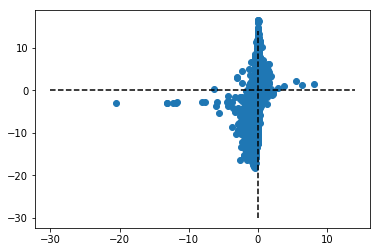

In [20]:
plt.scatter(data["temperature scale_surface_K"], pt_diff)
plt.plot(np.arange(-30, 15), np.zeros(45), 'k--')
plt.plot(np.zeros(45), np.arange(-30, 15),  'k--')

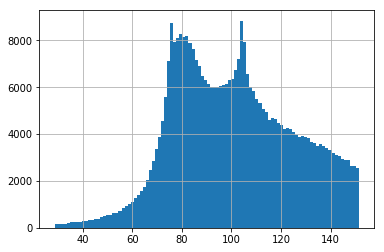

In [38]:
scale_diff = np.where((data["temperature scale_surface_K"] > 0) & (pt_diff < 0))[0]
data.loc[scale_diff, "zenith_0 m_degrees"].hist(bins=100)

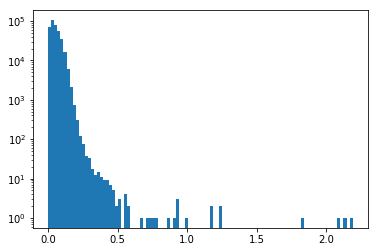

In [61]:
plt.hist(data.loc[scale_diff, "temperature scale_surface_K"], bins=100)
plt.gca().set_yscale("log")

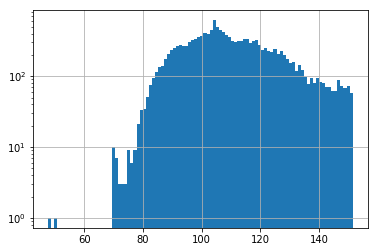

In [36]:
scale_diff = np.where((data["temperature scale_surface_K"] < 0) & (pt_diff > 0))[0]
data.loc[scale_diff, "zenith_0 m_degrees"].hist(bins=100)
plt.gca().set_yscale("log")
#data.loc[scale_diff, "bulk richardson_2 m_"].hist(bins=100)

In [53]:
np.count_nonzero((-data["temperature scale_surface_K"] > 0) == (data["sensible heat flux_surface_W m-2"] > 0))

735143

In [57]:
np.where((-data["temperature scale_surface_K"] > 0) != (data["sensible heat flux_surface_W m-2"] > 0))

(array([691546]),)

In [58]:
data.loc[691546, ["temperature scale_surface_K", "sensible heat flux_surface_W m-2"]]

temperature scale_surface_K        -9.51518e-06
sensible heat flux_surface_W m-2              0
Name: 691546, dtype: object

(0, 0.2)

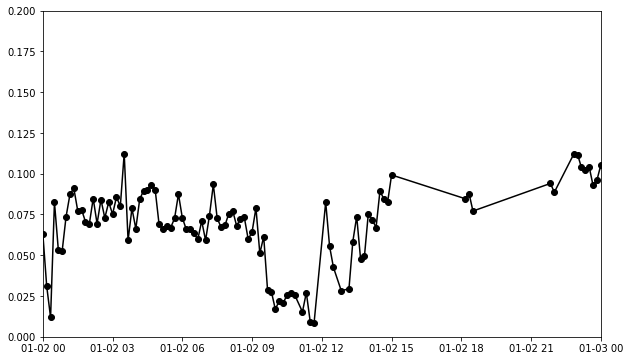

In [49]:
times = pd.DatetimeIndex(data["Time"])
plt.figure(figsize=(10, 6))
plt.plot(times[scale_diff], data.loc[scale_diff, "temperature scale_surface_K"], 'ko-')
plt.xlim('2014-01-02', '2014-01-03')
plt.ylim(0, 0.2)

In [40]:
scale_diff

array([     0,      1,      3, ..., 735140, 735141, 735143])

In [ ]:
scale_diff = np.where((data["temperature scale_surface_K"] > 0) & (pt_diff < 0))[0]
data.loc[scale_diff, "zenith_0 m_degrees"].hist(bins=100)

In [107]:
data["friction velocity_surface_m s-1"].min()

0.001

In [147]:
t_diff = (data["virtual potential temperature_10 m_K"] - data["skin virtual potential temperature_0 m_K"])

(734631.0, 734633.0)

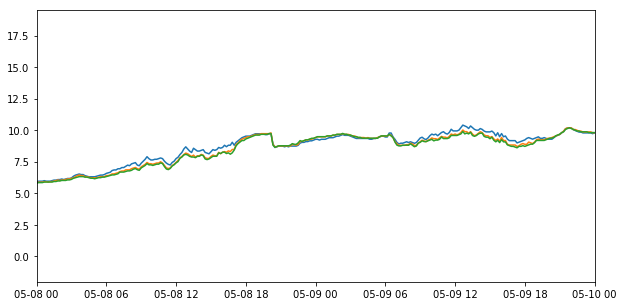

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(pd.DatetimeIndex(data["Time"]), data["mixing ratio_2 m_g kg-1"])
plt.plot(pd.DatetimeIndex(data["Time"]), data["mixing ratio_10 m_g kg-1"])
plt.plot(pd.DatetimeIndex(data["Time"]), data["mixing ratio_20 m_g kg-1"])


plt.xlim("2012-05-08", "2012-05-10")

(array([1.000e+00, 1.000e+00, 4.000e+00, 8.000e+00, 2.200e+01, 5.000e+01,
        1.510e+02, 3.980e+02, 7.170e+02, 1.263e+03, 2.125e+03, 3.329e+03,
        4.586e+03, 5.987e+03, 7.661e+03, 8.864e+03, 8.754e+03, 9.068e+03,
        9.123e+03, 7.884e+03, 6.680e+03, 5.778e+03, 5.031e+03, 4.703e+03,
        4.370e+03, 3.933e+03, 3.340e+03, 3.105e+03, 2.742e+03, 2.307e+03,
        2.075e+03, 1.812e+03, 1.617e+03, 1.582e+03, 1.503e+03, 1.358e+03,
        1.269e+03, 1.157e+03, 1.059e+03, 8.950e+02, 8.390e+02, 7.940e+02,
        7.120e+02, 5.610e+02, 4.850e+02, 3.940e+02, 3.860e+02, 3.520e+02,
        3.890e+02, 3.080e+02, 2.460e+02, 2.030e+02, 2.090e+02, 1.340e+02,
        9.100e+01, 6.200e+01, 5.800e+01, 4.000e+01, 4.500e+01, 3.200e+01,
        3.400e+01, 1.400e+01, 1.400e+01, 5.000e+00, 8.000e+00, 6.000e+00,
        8.000e+00, 5.000e+00, 1.000e+00, 7.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 6.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 2.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

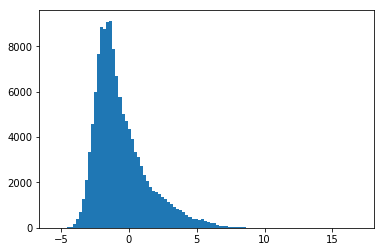

In [157]:
plt.hist(t_diff[idx], bins=100)

In [111]:
cq = np.maximum(data["friction velocity_surface_m s-1"], 0.1) * \
    data["moisture scale_surface_g kg-1"] / (data["skin saturation mixing ratio_0 m_g kg-1"] - data["mixing ratio_10 m_g kg-1"])

In [156]:
idx = data["zenith_0 m_degrees"] > 120
np.corrcoef(ch[idx], cq[idx])

array([[1.00000000e+00, 7.46854315e-09],
       [7.46854315e-09, 1.00000000e+00]])

(-0.1, 0.1)

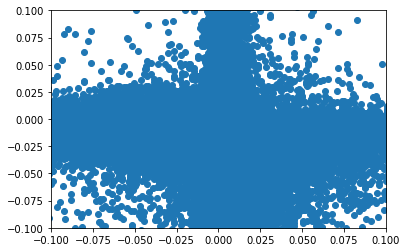

In [145]:
plt.scatter(ch[idx], cq[idx])
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)

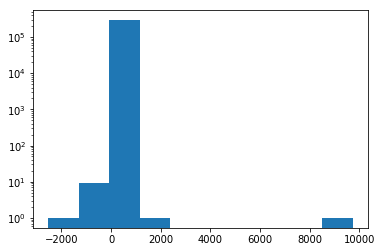

In [146]:
plt.hist(ch[idx])
plt.gca().set_yscale("log")

In [20]:
np.argmin(np.abs(ch - cq))

701656

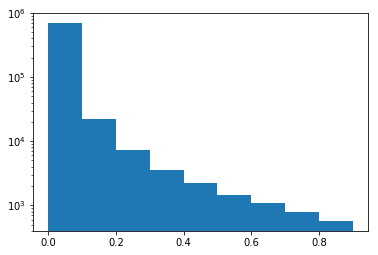

In [25]:
plt.hist(np.abs(ch - cq), bins=np.arange(0, 1, 0.1))
plt.gca().set_yscale("log")

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), ch, 'r-', label="CH")
plt.plot(pd.DatetimeIndex(data["Time"]), cq, 'g-', label="CQ")
plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.xlim("2011-05-01", "2011-05-08")
plt.ylabel("Exchange Coefficient (m s-1)")
plt.title("Cabauw Exchange Coefficients")
plt.xlabel("Time (UTC)")
plt.ylim(-0.1, 0.1)
plt.savefig("ch_cq_series.png", dpi=200, bbox_inches="tight")

NameError: name 'ch' is not defined

<Figure size 720x432 with 0 Axes>

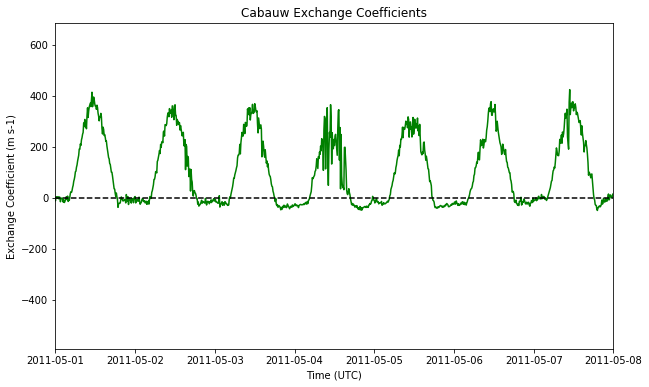

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), data["latent heat flux_surface_W m-2"], 'g-')
plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.xlim("2011-05-01", "2011-05-08")
plt.ylabel("Exchange Coefficient (m s-1)")
plt.title("Cabauw Exchange Coefficients")
plt.xlabel("Time (UTC)")
#plt.ylim(-0.1, 0.1)
plt.savefig("ch_cq_series.png", dpi=200, bbox_inches="tight")

(734258.0, 734265.0)

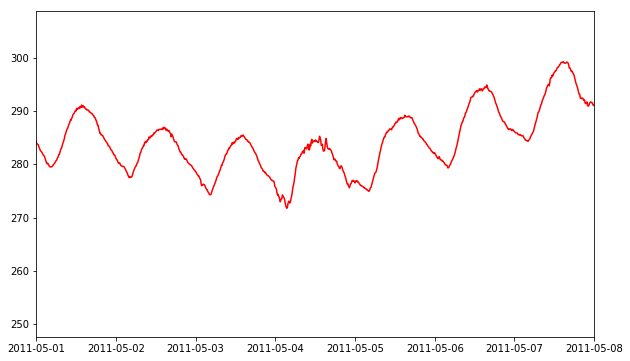

In [118]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), data["potential temperature_2 m_K"], 'r-')
#plt.plot(pd.DatetimeIndex(data["Time"]), cq, 'g-')
#plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.xlim("2011-05-01", "2011-05-08")

(2, 10)

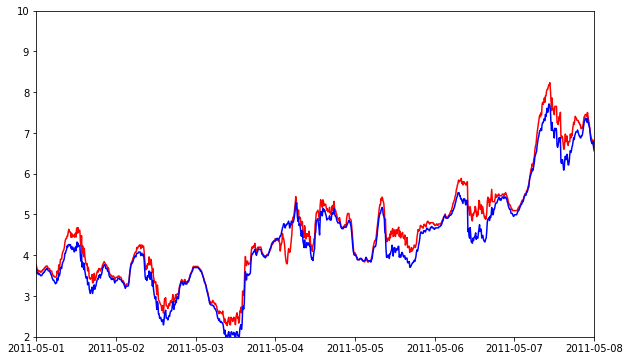

In [129]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), data["mixing ratio_2 m_g kg-1"], 'r-')
plt.plot(pd.DatetimeIndex(data["Time"]), data["mixing ratio_10 m_g kg-1"], 'b-')

#plt.plot(pd.DatetimeIndex(data["Time"]), data["skin saturation mixing ratio_0 m_g kg-1"], 'g-')
#plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')
plt.xlim("2011-05-01", "2011-05-8")
plt.ylim(2, 10)

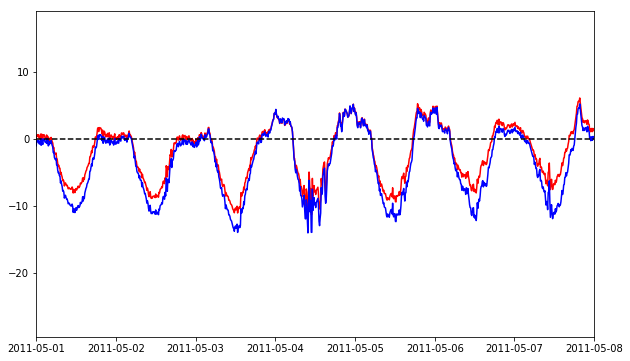

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), (data["potential temperature_10 m_K"] - data["skin potential temperature_0 m_K"]), 'r-')
plt.plot(pd.DatetimeIndex(data["Time"]), (data["virtual potential temperature_10 m_K"] - data["skin virtual potential temperature_0 m_K"]), 'b-')

plt.xlim("2011-05-01", "2011-05-08")
plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')


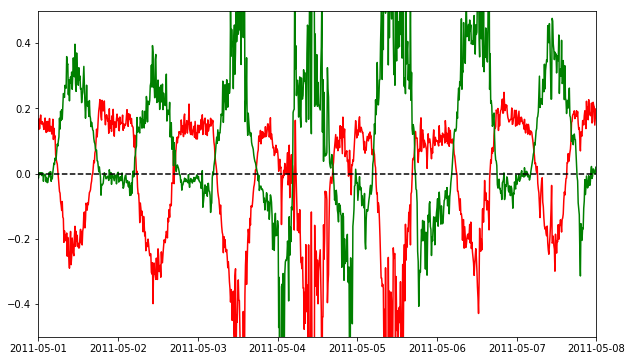

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(pd.DatetimeIndex(data["Time"]), data["temperature scale_surface_K"], 'r-')
plt.plot(pd.DatetimeIndex(data["Time"]), data["moisture scale_surface_g kg-1"], 'g-')

plt.xlim("2011-05-01", "2011-05-08")
plt.ylim(-0.5, 0.5)
plt.plot(pd.DatetimeIndex(data["Time"]), np.zeros(data.shape[0]), 'k--')


In [13]:
data.columns

Index(['Time', 'global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_2 m_K', 'temperature_10 m_K',
       'temperature_20 m_K', 'temperature_40 m_K', 'pressure_2 m_hPa',
       'potential temperature_2 m_K', 'potential temperature_10 m_K',
       'potential temperature_20 m_K', 'potential temperature_40 m_K',
       'virtual potential temperature_2 m_K',
       'virtual potential temperature_10 m_K',
       'virtual potential temperature_20 m_K',
       'virtual potential temperature_40 m_K', 'mixing ratio_2 m_g kg-1',
       'mixing ratio_10 m_g kg-1', 'mixing ratio_20 m_g kg-1',
       'mixing ratio_40 m_g kg-1', 'relative humidity_2 m_%',
       'relative humidity_10 m_%', 'relative humidity_20 m_%',
       'relative humidity_40 m_%', 'temperature change_4 m_K m-1',
       'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
       'mixing ratio change_4 m_g kg-1 m-1',
       'mixing ratio change_15 m_g kg-1 m-1',
   

In [27]:
data

,Time,global horizontal irradiance_0 m_W m-2,zenith_0 m_degrees,azimuth_0 m_degrees,temperature_2 m_K,temperature_10 m_K,temperature_20 m_K,temperature_40 m_K,pressure_2 m_hPa,potential temperature_2 m_K,...,friction velocity_surface_m s-1,temperature scale_surface_K,moisture scale_surface_g kg-1,bulk richardson_10 m_,bulk richardson_2 m_,bulk richardson_10-2 m_,obukhov length_surface_m,sensible heat flux_surface_W m-2,latent heat flux_surface_W m-2,soil heat flux_surface_W m-2
0,2002-12-06 11:00:00,30.344975,74.785305,172.519924,276.94998,276.85000,276.85000,276.65000,1029.1,274.689482,...,0.403107,0.003836,0.018245,-0.028411,-0.005476,-0.001023,1137.096523,-2.006770,21.518290,-5.167618
1,2002-12-06 11:10:00,28.422215,74.617537,174.907488,276.94998,276.85000,276.85000,276.65000,1029.0,274.697109,...,0.382195,0.012033,0.020325,-0.026373,-0.005091,-0.000908,849.502293,-5.967686,22.725586,-5.155605
2,2002-12-06 11:20:00,26.398144,74.513746,177.300503,276.85000,276.75000,276.75000,276.55000,1029.0,274.597942,...,0.437964,-0.002425,0.010481,-0.028671,-0.005550,-0.000912,-1341.803444,1.378475,13.433453,-5.233712
3,2002-12-06 11:30:00,18.420874,74.474228,179.696403,276.75000,276.65000,276.65000,276.44998,1029.0,274.498755,...,0.411857,0.000890,0.007648,-0.032077,-0.006204,-0.001046,1186.169231,-0.475897,9.221571,-5.393440
4,2002-12-06 11:40:00,12.303274,74.499094,182.092586,276.65000,276.55000,276.55000,276.44998,1028.9,274.407188,...,0.359413,0.011364,0.013768,-0.028007,-0.005369,-0.001151,794.631232,-5.304996,14.490702,-5.619604
5,2002-12-06 11:50:00,15.182462,74.588274,184.486446,276.65000,276.55000,276.55000,276.35000,1028.7,274.422430,...,0.476261,0.004674,0.012582,-0.029540,-0.005651,-0.001273,1585.708192,-2.890719,17.544598,-5.892313
6,2002-12-06 12:00:00,14.469632,74.741517,186.875404,276.55000,276.44998,276.44998,276.25000,1028.7,274.323235,...,0.499015,0.009760,0.008668,-0.024309,-0.004677,-0.000914,1740.214882,-6.328166,12.670034,-6.189555
7,2002-12-06 12:10:00,19.445660,74.958392,189.256945,276.44998,276.35000,276.35000,276.25000,1028.7,274.224021,...,0.361803,0.011372,0.017391,-0.023756,-0.004539,-0.001054,804.158250,-5.347807,18.439133,-6.490038
8,2002-12-06 12:20:00,16.374928,75.238297,191.628644,276.35000,276.35000,276.25000,276.15000,1028.7,274.124846,...,0.317639,0.019588,0.019290,-0.026301,-0.005235,-0.000127,359.835704,-8.087300,17.956491,-6.775868
9,2002-12-06 12:30:00,6.115935,75.580461,193.988196,276.15000,276.05000,276.05000,275.85000,1028.7,273.926456,...,0.442742,0.002686,0.006806,-0.025688,-0.004948,-0.000937,1367.885906,-1.547663,8.840096,-7.034682


In [134]:
x = np.arange(0, 32 * np.pi, np.pi / 16)
y = np.sin(x)

(0, 6.283185307179586)

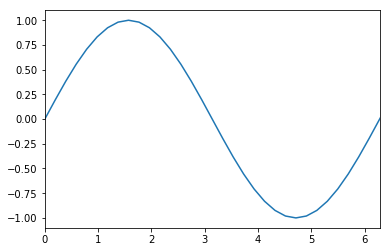

In [159]:
plt.plot(x, y)
plt.xlim(0, 2* np.pi)

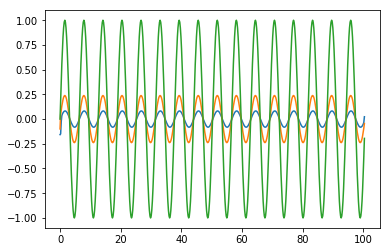

In [135]:
plt.plot(x, cwt(y, ricker, [1, 0.5]).T)
plt.plot(x, y)

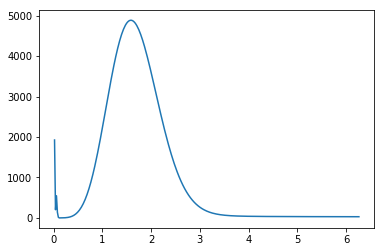

In [160]:
widths = np.arange(0.1, 32, 0.1)
plt.plot(widths * np.pi / 16, np.sum(cwt(y, ricker, widths) ** 2, axis=1))

In [137]:
np.argmax(np.sum(cwt(y, ricker, widths) ** 2, axis=1))

80

In [139]:
widths[80]

8.1

In [141]:
8.1 * np.pi / 16

1.5904312808798327

In [55]:
np.corrcoef((data.loc[idxs, "potential temperature_10 m_K"] - data.loc[idxs, "skin potential temperature_0 m_K"]), 
            data.loc[idxs, "temperature scale_surface_K"])

array([[1.        , 0.73191464],
       [0.73191464, 1.        ]])

In [49]:
np.corrcoef((data.loc[idxs, "potential temperature_40 m_K"] - data.loc[idxs, "potential temperature_10 m_K"]), 
            (data.loc[idxs, "potential temperature_10 m_K"] - data.loc[idxs, "skin potential temperature_0 m_K"]))

array([[1.        , 0.46544519],
       [0.46544519, 1.        ]])

In [56]:
np.corrcoef(data.loc[idxs, "wind speed_10 m_m s-1"] * 
            (data.loc[idxs, "potential temperature_10 m_K"] - data.loc[idxs,"skin potential temperature_0 m_K"]),
            data.loc[idxs, "friction velocity_surface_m s-1"] * data.loc[idxs, "temperature scale_surface_K"])

array([[1.        , 0.57933186],
       [0.57933186, 1.        ]])

In [65]:
np.corrcoef((data.loc[idxs, "potential temperature_10 m_K"] - data.loc[idxs, "skin potential temperature_0 m_K"]), 
            data.loc[idxs, "sensible heat flux_surface_W m-2"])

array([[ 1.        , -0.77201363],
       [-0.77201363,  1.        ]])

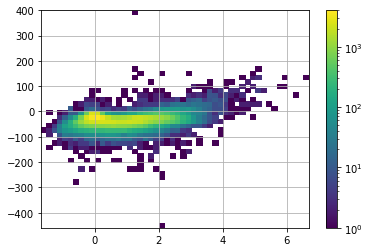

In [238]:
idxs = (data["bulk richardson_10 m_"] < 0.01) & (data["bulk richardson_10 m_"] > -0.01)

plt.hist2d(-(data.loc[idxs, "virtual potential temperature_10 m_K"] - data.loc[idxs, "skin virtual potential temperature_0 m_K"]), 
           data.loc[idxs, "sensible heat flux_surface_W m-2"], 50, cmin=1, norm=LogNorm())
plt.colorbar()
plt.grid()

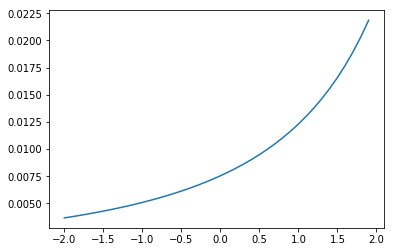

In [247]:
psim_vals = np.arange(-2, 2, 0.1)
cd = 0.4 ** 2 / (np.log(10 / 0.1) - psim_vals)** 2
plt.plot(psim_vals, cd)

In [252]:
def skin_temperature(upward_longwave_irradiance_W_m2, emissivity=0.97):
    """
    Calculates the radiative skin temperature from the upward longwave irradiance.

    Args:
        upward_longwave_irradiance_W_m2: The upward longwave irradiance from the surface
        emissivity: How much energy is emitted in comparison to a blackbody. Ranges from 0 to 1.

    Returns:
        The skin temperature in Kelvin.
    """
    sigma = 5.673067e-8
    return (upward_longwave_irradiance_W_m2 / (emissivity * sigma)) ** 0.25


def potential_temperature(temperature_k, pressure_hpa, pressure_reference_hpa=1000.0):
    """
    Convert temperature to potential temperature based on the available pressure. Potential temperature is at a
    reference pressure of 1000 mb.

    Args:
        temperature_k: The air temperature in units K
        pressure_hpa: The atmospheric pressure in units hPa
        pressure_reference_hpa: The reference atmospheric pressure for the potential temperature in hPa;
            default 1000 hPa

    Returns:
        The potential temperature in units K
    """
    return temperature_k * (pressure_reference_hpa / pressure_hpa) ** (2.0 / 7.0)

In [14]:
new_skin_t = potential_temperature(skin_temperature(data["upward longwave irradiance_0 m_W m-2"], emissivity=1.0),
                                   data["pressure_2 m_hPa"])

NameError: name 'potential_temperature' is not defined

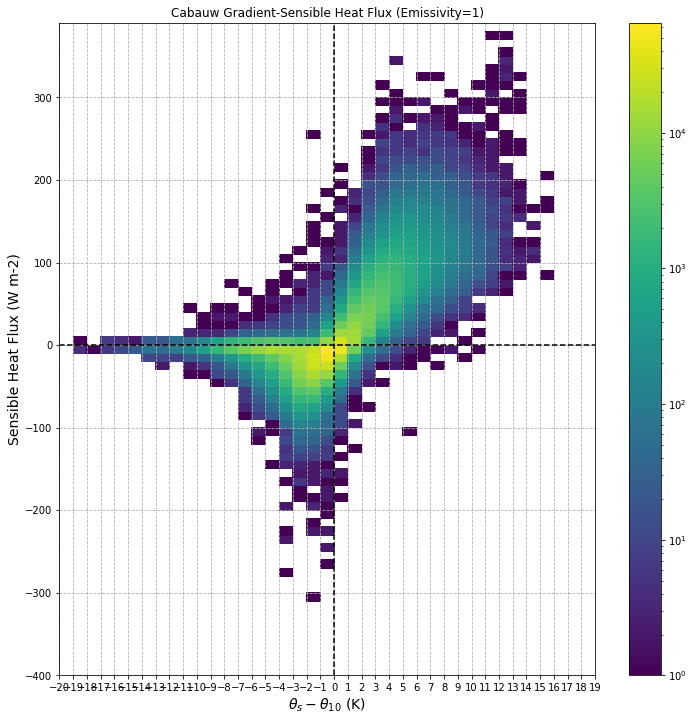

In [264]:
plt.figure(figsize=(12, 12))
plt.hist2d(-(data.loc[:, "potential temperature_10 m_K"] - new_skin_t), 
           data["sensible heat flux_surface_W m-2"][:], (np.arange(-20, 20, 1), np.arange(-400, 400, 10)), cmin=1, norm=LogNorm())
plt.plot(np.arange(-20, 20, 1), np.zeros(40), 'k--')
plt.plot(np.zeros(80), np.arange(-400, 400, 10),  'k--')
plt.colorbar()
plt.grid(linestyle="--")
plt.xticks(np.arange(-20, 20, 1))
plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
plt.ylabel("Sensible Heat Flux (W m-2)", fontsize=14)
plt.xlabel("$\\theta_{s}-\\theta_{10}$ (K)", fontsize=14)
plt.savefig("counter_gradient_fluxes_new.png", dpi=200, bbox_inches="tight")

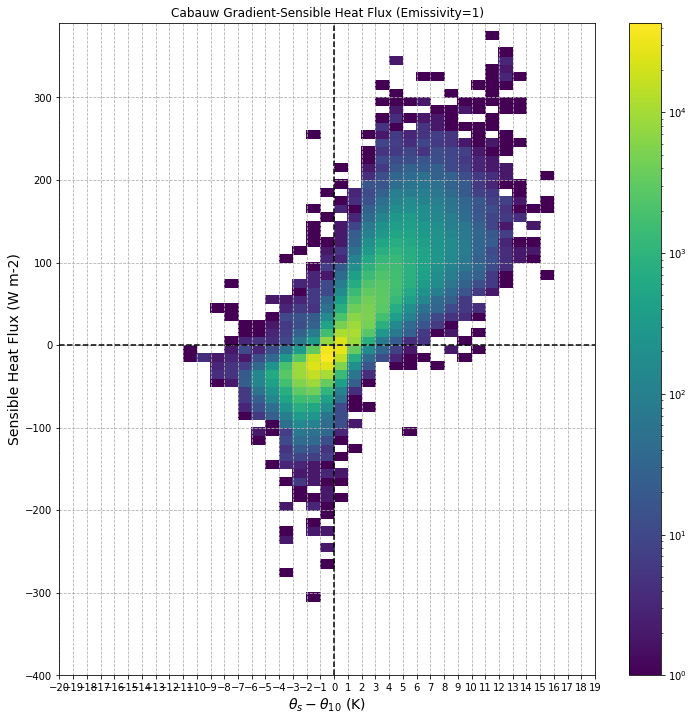

In [29]:
plt.figure(figsize=(12, 12))
plt.hist2d(data.loc[np.log10(data["friction velocity_surface_m s-1"]) > -0.8, "potential temperature skin change_10 m_K m-1"] * 10, 
           data.loc[np.log10(data["friction velocity_surface_m s-1"]) > -0.8,  "sensible heat flux_surface_W m-2"], (np.arange(-20, 20, 1), np.arange(-400, 400, 10)), cmin=1, norm=LogNorm())
plt.plot(np.arange(-20, 20, 1), np.zeros(40), 'k--')
plt.plot(np.zeros(80), np.arange(-400, 400, 10),  'k--')
plt.colorbar()
plt.grid(linestyle="--")
plt.xticks(np.arange(-20, 20, 1))
plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
plt.ylabel("Sensible Heat Flux (W m-2)", fontsize=14)
plt.xlabel("$\\theta_{s}-\\theta_{10}$ (K)", fontsize=14)
plt.savefig("counter_gradient_fluxes_new.png", dpi=200, bbox_inches="tight")

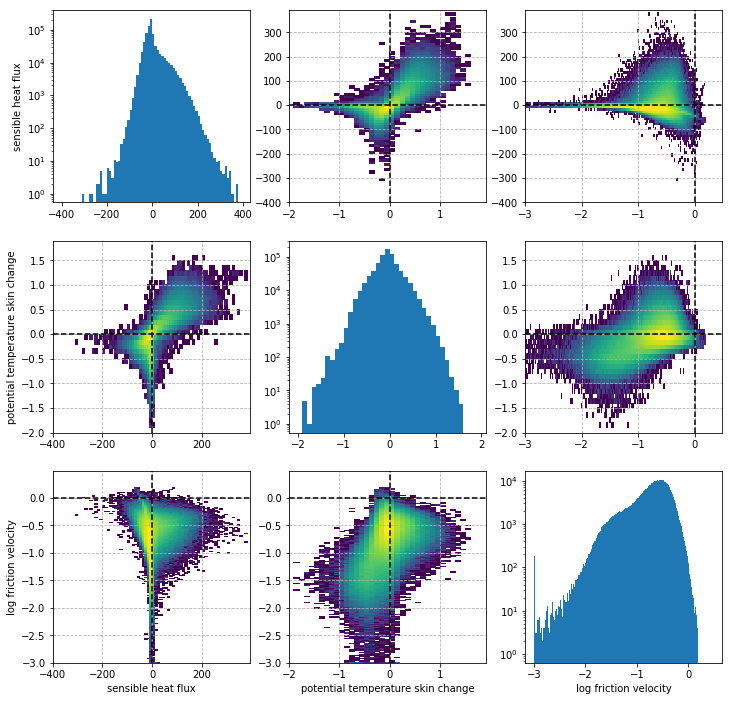

In [54]:
variables = ["sensible heat flux_surface_W m-2", "potential temperature skin change_10 m_K m-1", "log friction velocity_surface_m s-1"]
variable_ranges = [np.arange(-400, 400, 10), np.arange(-2, 2, 0.1), np.arange(-3, 0.5, 0.01)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for r in range(len(variables)):
    for c in range(len(variables)):
        if r != c:
            axes[c,r].hist2d(data.loc[:, variables[r]], data.loc[:, variables[c]], 
                       (variable_ranges[r], variable_ranges[c]), cmin=1, norm=LogNorm())
            axes[c,r].plot(variable_ranges[r], np.zeros(len(variable_ranges[r])), 'k--')
            axes[c,r].plot(np.zeros(len(variable_ranges[c])), variable_ranges[c],  'k--')
            axes[c,r].grid(linestyle="--")
            #plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
        else:
            axes[r,c].hist(data.loc[:, variables[r]], bins=variable_ranges[r])
            axes[r,c].set_yscale("log")
        if c == 0:
            axes[r, c].set_ylabel(variables[r].split("_")[0])
        if r == 2:
            axes[r, c].set_xlabel(variables[c].split("_")[0])
plt.savefig("flux_effect_hist.png", dpi=200, bbox_inches="tight")

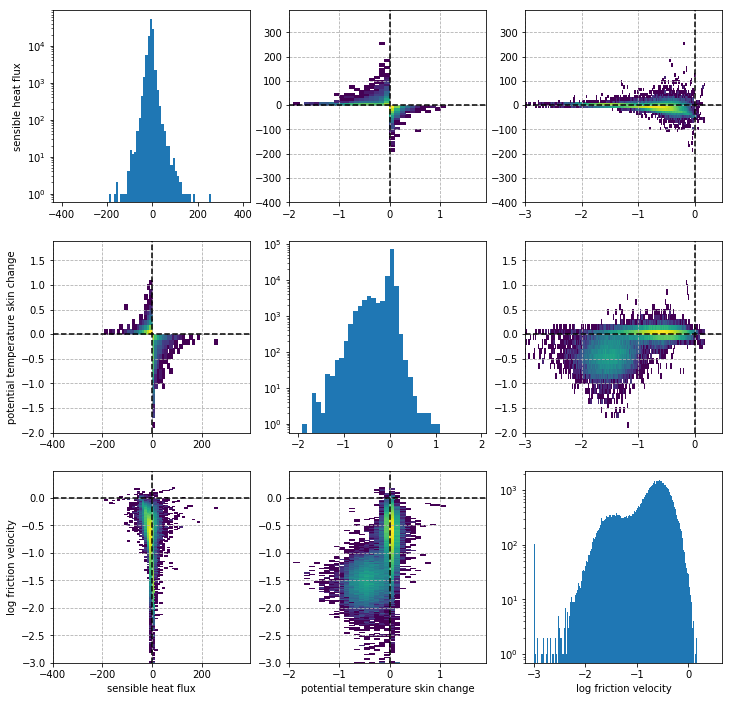

In [51]:
variables = ["sensible heat flux_surface_W m-2", "potential temperature skin change_10 m_K m-1", "log friction velocity_surface_m s-1"]
variable_ranges = [np.arange(-400, 400, 10), np.arange(-2, 2, 0.1), np.arange(-3, 0.5, 0.01)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idxs = data["flux_grad"] == 0
for r in range(len(variables)):
    for c in range(len(variables)):
        if r != c:
            axes[c,r].hist2d(data.loc[idxs, variables[r]], data.loc[idxs, variables[c]], 
                       (variable_ranges[r], variable_ranges[c]), cmin=1, norm=LogNorm())
            axes[c,r].plot(variable_ranges[r], np.zeros(len(variable_ranges[r])), 'k--')
            axes[c,r].plot(np.zeros(len(variable_ranges[c])), variable_ranges[c],  'k--')
            axes[c,r].grid(linestyle="--")
            #plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
        else:
            axes[r,c].hist(data.loc[idxs, variables[r]], bins=variable_ranges[r])
            axes[r,c].set_yscale("log")
        if c == 0:
            axes[r, c].set_ylabel(variables[r].split("_")[0])
        if r == 2:
            axes[r, c].set_xlabel(variables[c].split("_")[0])
plt.savefig("flux_effect_hist_bad.png", dpi=200, bbox_inches="tight")

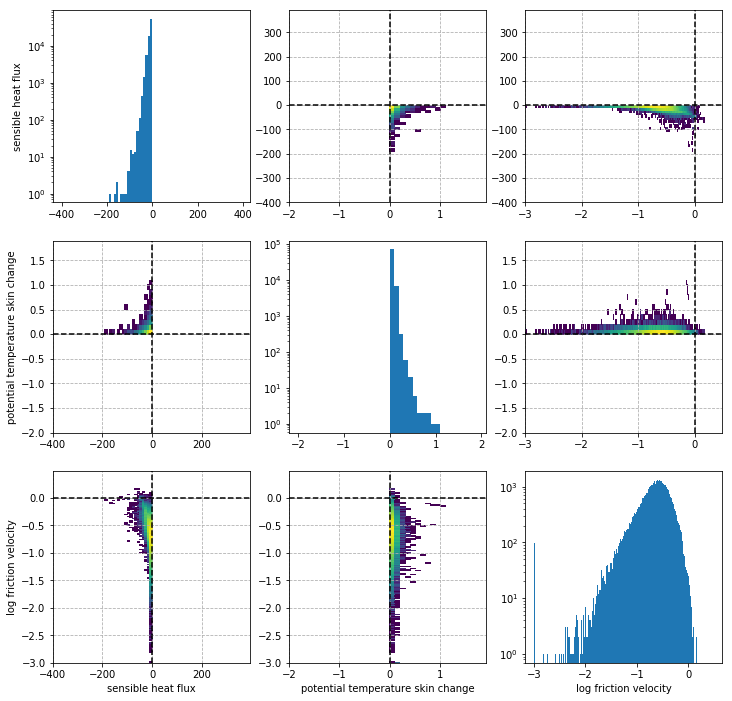

In [56]:
variables = ["sensible heat flux_surface_W m-2", "potential temperature skin change_10 m_K m-1", "log friction velocity_surface_m s-1"]
variable_ranges = [np.arange(-400, 400, 10), np.arange(-2, 2, 0.1), np.arange(-3, 0.5, 0.01)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idxs = (data["sensible heat flux_surface_W m-2"] < 0) & (data["potential temperature skin change_10 m_K m-1"] > 0)
for r in range(len(variables)):
    for c in range(len(variables)):
        if r != c:
            axes[c,r].hist2d(data.loc[idxs, variables[r]], data.loc[idxs, variables[c]], 
                       (variable_ranges[r], variable_ranges[c]), cmin=1, norm=LogNorm())
            axes[c,r].plot(variable_ranges[r], np.zeros(len(variable_ranges[r])), 'k--')
            axes[c,r].plot(np.zeros(len(variable_ranges[c])), variable_ranges[c],  'k--')
            axes[c,r].grid(linestyle="--")
            #plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
        else:
            axes[r,c].hist(data.loc[idxs, variables[r]], bins=variable_ranges[r])
            axes[r,c].set_yscale("log")
        if c == 0:
            axes[r, c].set_ylabel(variables[r].split("_")[0])
        if r == 2:
            axes[r, c].set_xlabel(variables[c].split("_")[0])
plt.savefig("flux_effect_hist_bad_neg_flux.png", dpi=200, bbox_inches="tight")

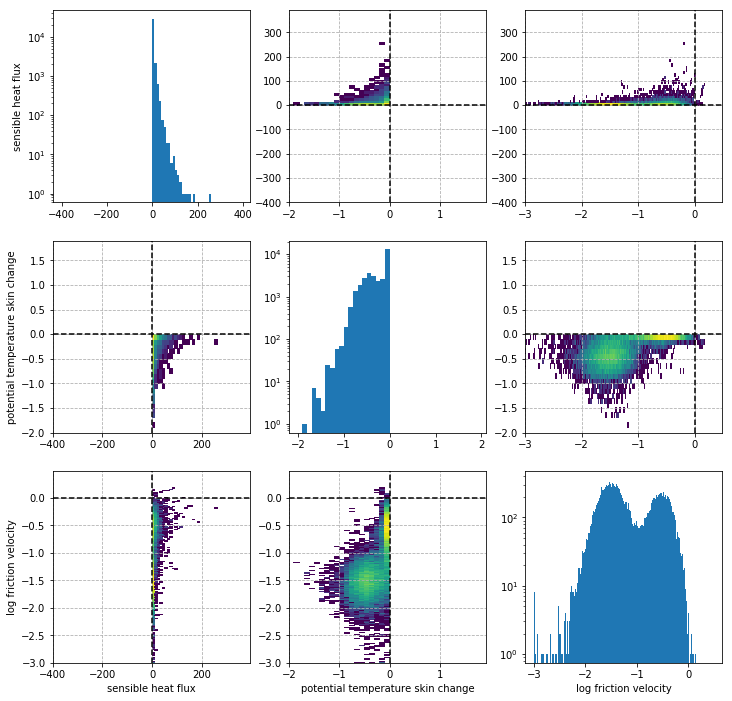

In [57]:
variables = ["sensible heat flux_surface_W m-2", "potential temperature skin change_10 m_K m-1", "log friction velocity_surface_m s-1"]
variable_ranges = [np.arange(-400, 400, 10), np.arange(-2, 2, 0.1), np.arange(-3, 0.5, 0.01)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idxs = (data["sensible heat flux_surface_W m-2"] > 0) & (data["potential temperature skin change_10 m_K m-1"] < 0)
for r in range(len(variables)):
    for c in range(len(variables)):
        if r != c:
            axes[c,r].hist2d(data.loc[idxs, variables[r]], data.loc[idxs, variables[c]], 
                       (variable_ranges[r], variable_ranges[c]), cmin=1, norm=LogNorm())
            axes[c,r].plot(variable_ranges[r], np.zeros(len(variable_ranges[r])), 'k--')
            axes[c,r].plot(np.zeros(len(variable_ranges[c])), variable_ranges[c],  'k--')
            axes[c,r].grid(linestyle="--")
            #plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
        else:
            axes[r,c].hist(data.loc[idxs, variables[r]], bins=variable_ranges[r])
            axes[r,c].set_yscale("log")
        if c == 0:
            axes[r, c].set_ylabel(variables[r].split("_")[0])
        if r == 2:
            axes[r, c].set_xlabel(variables[c].split("_")[0])
plt.savefig("flux_effect_hist_bad_pos_flux.png", dpi=200, bbox_inches="tight")

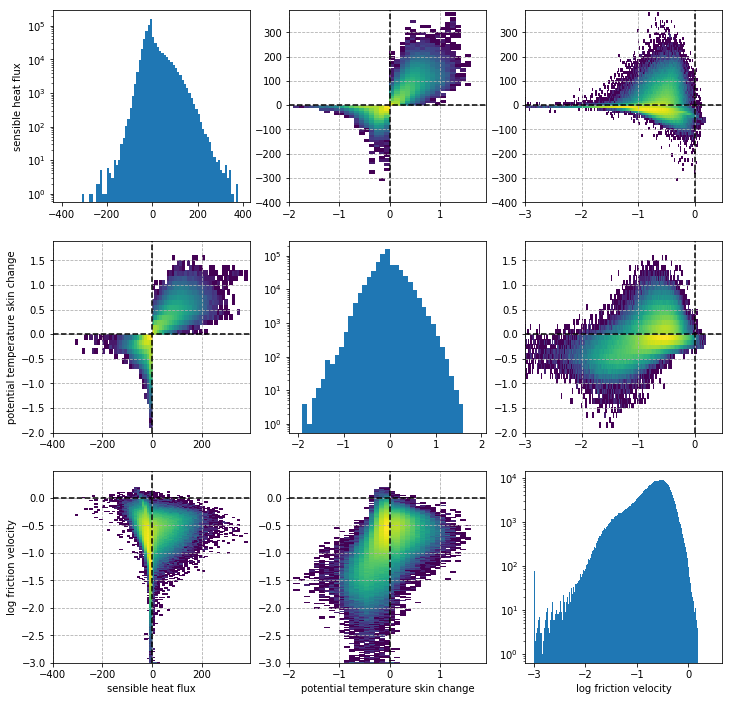

In [53]:
variables = ["sensible heat flux_surface_W m-2", "potential temperature skin change_10 m_K m-1", "log friction velocity_surface_m s-1"]
variable_ranges = [np.arange(-400, 400, 10), np.arange(-2, 2, 0.1),np.arange(-3, 0.5, 0.01)]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
idxs = data["flux_grad"] == 1
for r in range(len(variables)):
    for c in range(len(variables)):
        if r != c:
            axes[c,r].hist2d(data.loc[idxs, variables[r]], data.loc[idxs, variables[c]], 
                       (variable_ranges[r], variable_ranges[c]), cmin=1, norm=LogNorm())
            axes[c,r].plot(variable_ranges[r], np.zeros(len(variable_ranges[r])), 'k--')
            axes[c,r].plot(np.zeros(len(variable_ranges[c])), variable_ranges[c],  'k--')
            axes[c,r].grid(linestyle="--")
            #plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=1)")
        else:
            axes[r,c].hist(data.loc[idxs, variables[r]], bins=variable_ranges[r])
            axes[r,c].set_yscale("log")
        if c == 0:
            axes[r, c].set_ylabel(variables[r].split("_")[0])
        if r == 2:
            axes[r, c].set_xlabel(variables[c].split("_")[0])
plt.savefig("flux_effect_hist_good.png", dpi=200, bbox_inches="tight")

(array([2.24000e+02, 3.40000e+01, 8.40000e+01, 9.10000e+01, 1.51000e+02,
        1.83000e+02, 2.48000e+02, 4.81000e+02, 8.27000e+02, 1.52500e+03,
        3.02000e+03, 5.46500e+03, 9.04800e+03, 1.25980e+04, 1.66030e+04,
        1.97320e+04, 2.29210e+04, 2.78910e+04, 3.62420e+04, 4.96260e+04,
        6.92750e+04, 9.05720e+04, 1.06602e+05, 1.08329e+05, 8.43090e+04,
        4.58960e+04, 1.69650e+04, 5.19900e+03, 8.78000e+02, 1.25000e+02]),
 array([-3.        , -2.89367438, -2.78734877, -2.68102315, -2.57469754,
        -2.46837192, -2.3620463 , -2.25572069, -2.14939507, -2.04306945,
        -1.93674384, -1.83041822, -1.72409261, -1.61776699, -1.51144137,
        -1.40511576, -1.29879014, -1.19246452, -1.08613891, -0.97981329,
        -0.87348768, -0.76716206, -0.66083644, -0.55451083, -0.44818521,
        -0.34185959, -0.23553398, -0.12920836, -0.02288275,  0.08344287,
         0.18976849]),
 <a list of 30 Patch objects>)

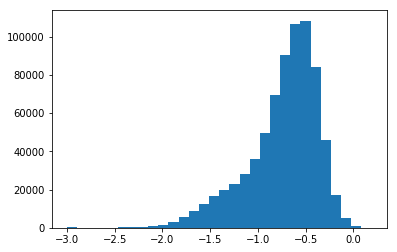

In [26]:
plt.hist(np.log10(data["friction velocity_surface_m s-1"]), bins=30)

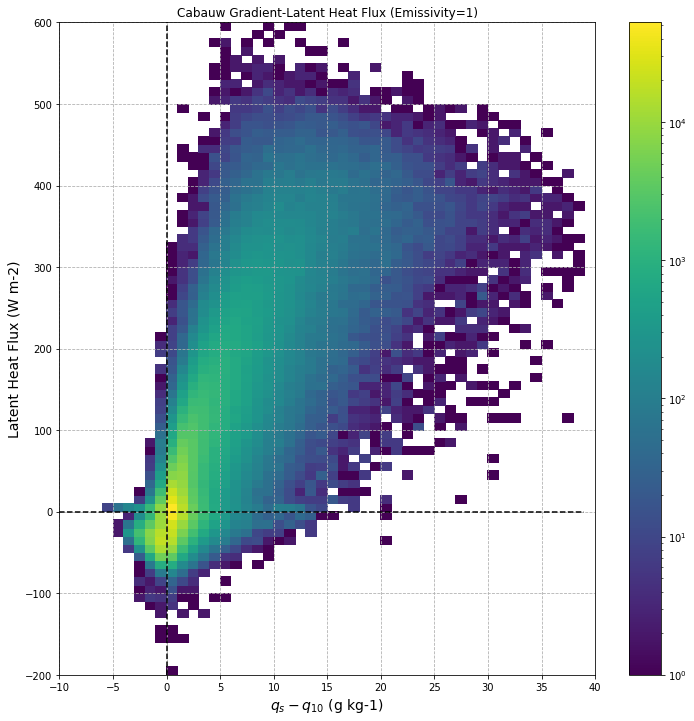

In [59]:
plt.figure(figsize=(12, 12))
plt.hist2d(data.loc[:, "mixing ratio skin change_10 m_g kg-1 m-1"] * 10, 
           data.loc[:, "latent heat flux_surface_W m-2"], (np.arange(-10, 40, 1), np.arange(-200, 610, 10)), cmin=1, norm=LogNorm())
plt.plot(np.arange(-10, 40, 1), np.zeros(50), 'k--')
plt.plot(np.zeros(81), np.arange(-200, 610, 10),  'k--')
plt.colorbar()
plt.grid(linestyle="--")
plt.xticks(np.arange(-10, 45, 5))
plt.title("Cabauw Gradient-Latent Heat Flux (Emissivity=1)")
plt.ylabel("Latent Heat Flux (W m-2)", fontsize=14)
plt.xlabel("$q_{s}-q_{10}$ (g kg-1)", fontsize=14)
plt.savefig("counter_gradient_latent_heat.png", dpi=200, bbox_inches="tight")

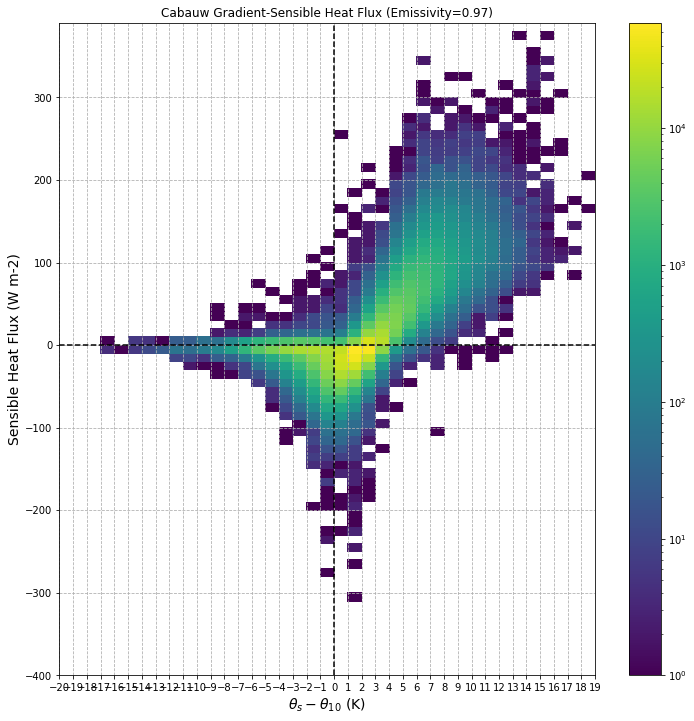

In [265]:
plt.figure(figsize=(12, 12))
plt.hist2d(-(data.loc[:, "potential temperature_10 m_K"] - data.loc[:, "skin potential temperature_0 m_K"]), 
           data["sensible heat flux_surface_W m-2"][:], (np.arange(-20, 20), np.arange(-400, 400, 10)), cmin=1, norm=LogNorm())
plt.plot(np.arange(-20, 20, 1), np.zeros(40), 'k--')
plt.plot(np.zeros(80), np.arange(-400, 400, 10),  'k--')
plt.colorbar()
plt.grid(linestyle="--")
plt.xticks(np.arange(-20, 20, 1))
plt.title("Cabauw Gradient-Sensible Heat Flux (Emissivity=0.97)")
plt.ylabel("Sensible Heat Flux (W m-2)", fontsize=14)
plt.xlabel("$\\theta_{s}-\\theta_{10}$ (K)", fontsize=14)
plt.savefig("counter_gradient_fluxes.png", dpi=200, bbox_inches="tight")

/Users/dgagne/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


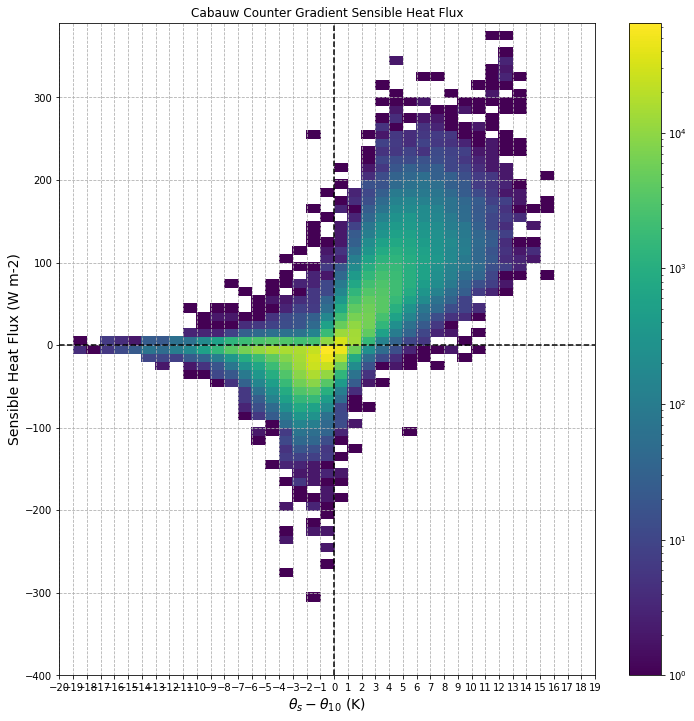

In [33]:
plt.figure(figsize=(12, 12))
plt.hist2d(-(data.loc[:, "potential temperature_10 m_K"] - data.loc[:, "skin potential temperature_0 m_K"]), 
           data["sensible heat flux_surface_W m-2"][:], (np.arange(-20, 20), np.arange(-400, 400, 10)), cmin=1, norm=LogNorm())
plt.plot(np.arange(-20, 20, 1), np.zeros(40), 'k--')
plt.plot(np.zeros(80), np.arange(-400, 400, 10),  'k--')
plt.colorbar()
plt.grid(linestyle="--")
plt.xticks(np.arange(-20, 20, 1))
plt.title("Cabauw Counter Gradient Sensible Heat Flux")
plt.ylabel("Sensible Heat Flux (W m-2)", fontsize=14)
plt.xlabel("$\\theta_{s}-\\theta_{10}$ (K)", fontsize=14)
plt.savefig("counter_gradient_fluxes.png", dpi=200, bbox_inches="tight")